In [483]:
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import time

# Zadanie 2
## Damian Baraniak 324851
#### WSI-24L-G104
Celem zadania jest implementacja algorymtu ewolucyjnego oraz weryfikacja jego działania na przykładzie minimalizacji dwóch funckcji dwuwymiarowych.
- Funkcja Himmelblau:
    $$ f(x,y)=(x^2+y-11)^2+(x+y^2-7)^2 $$ 
- Funckcja Ackleya w wersji dwuwymiarowej:
    $$ f(x,y) = -20\exp(-0.2\sqrt{0.5(x^2+y^2)})-\exp(0.5(\cos2\pi x+\cos2\pi y))+20+e $$

In [484]:
def himmelblau_function(x:float,y:float)->float:
    elem1 = (x**2 + y - 11)**2 
    elem2 = (x + y**2 - 7)**2
    return elem1+elem2

def ackley_function(x:float,y:float)->float:
    elem1 = np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))
    elem2 = np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    return -20*elem1-elem2+20+np.e

## Struktura algorytmu
Algorytm do poprawnego działania potrzebuje szeregu parametrów. Są to:
- funckcja oceny - funkcja oceniająca osobniki, który najlepiej spełnia wymagania, w naszym przypadku jest to minimalizowanie podanych funkcji
- populacja początkowa - określona grupa osobników początkowych, wygenerowana losowo w pewnym obszarze
- prawdopodobnieństwo krzyżowania - określa jak często będzie dochodzić do krzyżowania między osobnikami
- siła mutacji - określa jak bardzo cechy osobnika mogą się zmieniać w wyniku mutacji
- liczba iteracji - ile razy należy powtórzyć proces ewolucji

### Osobnik 
Do działania algorytmu potrzebny jest osobnik, który będzie podlegać ocenie, mutacji i krzyżowaniu w przypadku tego zadania będzie to dwuwymiarowy wektor $[x,y]$

### Proces
Cały proces zaczyna się od wylosowania początkowej populacji oraz oceny wszystkich jej osobników, następnie powtarza się:
- reprodukcje, czyli wybór osobników do dalszych działań
- krzyżowanie osobników, czyli mieszanie cech osobników
- mutacje osobników, czyli arbitralna, losowa zmiana cech osobnika
- ocene powstałych osobników
- porównanie najlepszych osobników
- sukcesja, czyli wybranie osobników przchodzących do następnej iteracji

W zadaniu wybrano metody: reprodukcji turniejowej, krzyżowania uśredniającego, mutacji rozkładem normalnym oraz sukcesję elitarną o elicie wielkości 1.

### Reprodukcja turniejowa
Z aktualnej populacji losuje się ze zwracaniem osobniki do grupy turniejowej, następnie z grupy wybiera takiego osobnika, którego cechy dają najlepszy wynik w tym przypadku, którego wartość jest najmniejsza. Proces jest powtarzany, aż powstanie nowa populacja o takim samym rozmiarze. Losowanie ze zwracaniem może powodować, że niektóre, lepsze osobniki znajdą się w nowej populacji kilka razy, dodatkowo każdy osobnik ma pewną szasnę przejścia dalej, nawet najgorszy, jeśli wylosuje sam siebie do turnieju.

In [485]:
def tournament_selection(population,competition):
    temp_population = []
    while len(temp_population)<len(population):
        # losowanie grup turniejowych
        group = random.choices(population,k=competition)
        # wybór najlepszego osobnika
        temp_population.append(min(group,key=lambda ind:ind.value))
    return temp_population

### Sukcjesja elitarna
Sukcesja elitarna polega na doklejeniu do aktualnej populacji $\eta$ najlepszych osobników z porzedniej populacji, a następnie odrzuceniu $\eta$ najgorszych osobników, aby końcowy rozmiar populacji nie uległ zmianie. Zbyt duża ilość osobników doklejanych może sprawić utknięcie w ekstremach lokalnych, dlatego postanowiono ustanowić rozmiar elity jako $\eta = 1$, zachowując w ten sposób najlepszego osobnika.

In [486]:
def succession_phase(population,best):
    population.append(deepcopy(best))
    # sortowanie populacji rosnąco względem wartości funkcji dla osobnika
    population.sort(key = lambda ind:ind.value)
    population.pop()

### Krzyżowanie uśredniające i mutacja
Dla każdego osobnika w populacji jest losowane czy dojdzie do krzyżowania, jeśli nie to taki osobnik przechodzi dalej. Jeśli dojdzie do krzyżowania, losowany jest kolejny rodzic, następnie ich cechy są uśredniane przy pomocy wag: $k_t = w_t\cdot R_{t1}+(1-w_t)\cdot R_{t2}$, dla każdej cechy losowana jest osobna waga. Powstały potomek przechodzi do dalej, a pierwszy rodzic zostaje zapomniany.
W algorytmie ewolucyjnym każdy osobnik przechodzi mutacje, jest to zmiana wszystkich cech osobnika: $x_{t} = x_t + \sigma \cdot N(0,1)$, $\sigma$ oznacza tutaj siłę mutacji, czyli zasięg zmian osobnika.

#### Implementacja osobnika z możliwością porównania osobników z operatorami mutacji oraz krzyżowania

In [487]:
class Individual:
    def __init__(self,position):
        self.position = position
        self.size = len(position)
        self.value = None

    def evaluate(self, func):
        self.value = func(*self.position)
    
    def __lt__(self,other):
        return self.value<other.value
      
    def __str__(self) -> str:
        return f"Position: [{self.position[0]:.5f}, {self.position[1]:.5f}]\t Value: {self.value:.5f}"
    
    def mutate(self, strength):
        temp_position = []
        for gene in self.position:
            temp_position.append(gene + strength*random.gauss(0,1))
        self.position = temp_position
    
    def crossover(self,other):
        assert self.size == other.size
        result_position = []
        for i in range(self.size):    
            weight = random.random()
            gene = self.position[i]*weight+other.position[i]*(1-weight)
            result_position.append(gene)
        return Individual(result_position)

#### Implementacja etapów krzyżowania i mutacji

In [488]:
def crossover_phase(population, probability):
    temp_population = []
    for individual in population:
        if random.random()<probability:
            other = random.choice(population)
            temp_population.append(individual.crossover(other))
        else:
            temp_population.append(individual)
    return temp_population


def mutate_phase(population,mutation_strentgth):
    temp_population = []
    for individual in population:
        individual.mutate(mutation_strentgth)
        temp_population.append(individual)
    return temp_population

### Generowanie populacji początkowej
Ponieważ funkcja jest w pewnym stopniu znana, możemy ustanowić pewne ograniczenia jeśli chodzi o generowane populacji początkowej. Kolejną rzeczą do rozpatrzenia jest rozmiar populacji, za mało osobników ograniczy możliwości przeszukiwania, a zbyt wiele spowolni proces przez często nieprzydatne obliczenia. 

In [489]:
def generate_population(size:int,restrictions):
    population = list()
    for _ in range(size):
        # Losowanie punktu początkowego przestrzegając ograniczeń
        position = [random.uniform(restrictions[i][0],restrictions[i][1]) for i in range(len(restrictions))]
        population.append(Individual(position))
    return population


### Ocena populacji 
Przed podejmowaniem decyzji o dalszym wyborze osobników, potrzeba możliwości sprawiedliwego porównania ich, do tego przyda się funckja oceny populacji. W tym przypadku minimalizujemy funkcje, więc sortujemy osobniki rosnąco w populacji. 

In [490]:
def rate_individuals(population,func):
    for individual in population:
        individual.evaluate(func)
    population.sort(key=lambda ind:ind.value)

## Implementacja algorytmu w języku Python
Złożenie wszystkich opisanych powyżej metod, znajduje podsumowanie poniżej jako algorytm ewolucyjny. Funkcja, aby była pomocna w celach naukowych zwraca listę składając się z najlepszych osobników w każdej iteracji. 

In [491]:
def evolutionary_algorithm(func,start_population,iteration_time,mutation_strength,crossover_probability):
    population = deepcopy(start_population)
    rate_individuals(population,func)
    best_individual = deepcopy(population[0])
    trace = [best_individual]
    for step in range(iteration_time):
        population = tournament_selection(population,2)
        population = crossover_phase(population,crossover_probability)
        population = mutate_phase(population,mutation_strength)
        rate_individuals(population,func)
        succession_phase(population,best_individual)
        if population[0]<best_individual:
            best_individual = deepcopy(population[0])
        trace.append(best_individual)
    return trace

### Przykładowy fragment kodu

In [492]:
func = himmelblau_function
restrictions = ((-10,10),(-10,10))
population_size = 10
iterations = 100
mutation_strength = 0.3
crossover_probability =  0.1

population = generate_population(population_size,restrictions)
trace = evolutionary_algorithm(func,population,iterations,mutation_strength,crossover_probability)

## Funkcje do odczytywania wyników algorytmów
Znajdowanie lepszego od aktualnie najlepszego osobnika nie zdarza się często, dlatego będą wypisywane tylko te populacje, w których doszło do poprawienia wyniku. Do wizualizacji wybrano wykres wartości najlepszego osobnika w skali logarytmicznej w zależności od numeru iteracji oraz mapę rzutującą pozycje punktu na funkcji. 

In [493]:
def plot_trace(func,trace):
    X = np.arange(-7, 7, 0.1)
    Y = np.arange(-7, 7, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = func(X,Y)
    plt.contourf(X,Y,Z,300,cmap="nipy_spectral")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.title(func.__name__.replace("_"," "))
    trace_x = [best.position[0] for best in trace]
    trace_y = [best.position[1] for best in trace]
    plt.scatter(trace_x,trace_y,s=5,c="red")
    plt.show()

def plot_values(trace,log=True):
    trace_values = [best.value for best in trace]
    steps = range(len(trace_values))
    plt.plot(steps,trace_values)
    if log:
        plt.yscale("log")
    plt.grid(True)
    plt.show()

def print_trace(trace):
    best = trace[0]
    for i, curr in enumerate(trace):
        if curr<best:
            best=curr
            print(f"Step: {i}\t {curr}")

## Eksperymenty
W trakcie eksperymentów należy sprawdzić wpływ ustawień algorytmu takich jak rozmiar populacji, ilość pokoleń, prwadopodobnieństwo mutacji, krzyżowania.

### Rozmiar populacji - $\mu$

In [494]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $\mu =5$

Algorytm zajął: 0.03029s
Step: 1	 Position: [2.46092, 2.13326]	 Value: 7.89967
Step: 3	 Position: [2.66917, 2.02064]	 Value: 3.50198
Step: 4	 Position: [3.06087, 1.57768]	 Value: 2.10553
Step: 5	 Position: [2.76957, 2.19762]	 Value: 1.64001
Step: 15	 Position: [3.11498, 2.12753]	 Value: 1.10134
Step: 17	 Position: [2.89283, 2.14628]	 Value: 0.48483
Step: 22	 Position: [3.02146, 2.08158]	 Value: 0.17006
Step: 93	 Position: [2.93309, 2.06472]	 Value: 0.14888
Step: 109	 Position: [3.00108, 1.97743]	 Value: 0.00812
Step: 576	 Position: [3.00856, 2.00388]	 Value: 0.00364


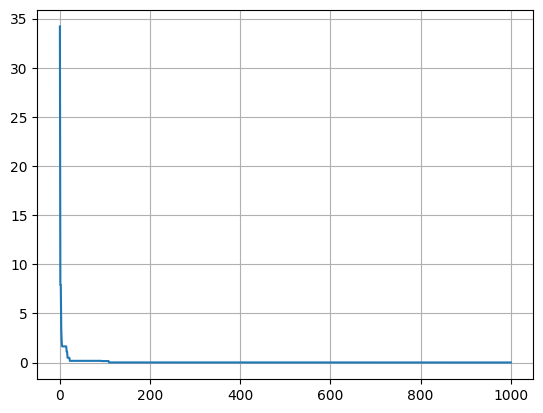

In [495]:
size = 5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu = 10$

Algorytm zajął: 0.05081s
Step: 3	 Position: [3.20691, 2.67842]	 Value: 15.28198
Step: 4	 Position: [3.18135, 2.58450]	 Value: 11.09380
Step: 7	 Position: [3.05611, 2.46533]	 Value: 5.20203
Step: 8	 Position: [2.90536, 2.46597]	 Value: 3.95436
Step: 9	 Position: [3.06473, 2.11568]	 Value: 0.55083
Step: 11	 Position: [2.95683, 2.04404]	 Value: 0.06363
Step: 14	 Position: [2.98347, 1.96281]	 Value: 0.04538
Step: 46	 Position: [2.97129, 2.03441]	 Value: 0.03090
Step: 221	 Position: [2.98583, 2.01708]	 Value: 0.00755
Step: 498	 Position: [2.98998, 2.01261]	 Value: 0.00389
Step: 705	 Position: [2.99895, 1.99255]	 Value: 0.00114


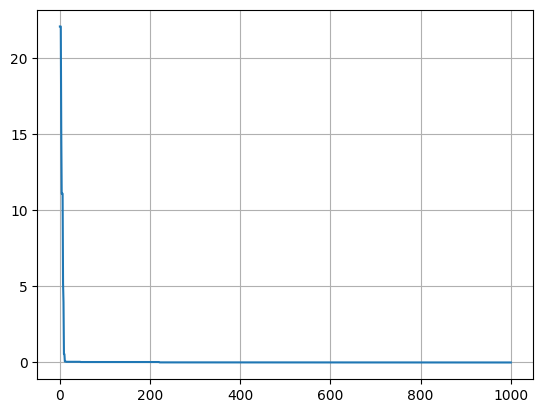

In [496]:
size = 10

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu =20$

Algorytm zajął: 0.09103s
Step: 1	 Position: [3.52882, -0.08611]	 Value: 13.86484
Step: 3	 Position: [3.51782, 2.07168]	 Value: 12.53568
Step: 5	 Position: [-2.50106, 3.27418]	 Value: 3.64893
Step: 7	 Position: [-2.72022, 3.28455]	 Value: 1.24046
Step: 9	 Position: [2.95948, 1.88936]	 Value: 0.34568
Step: 11	 Position: [3.07328, 1.94159]	 Value: 0.17413
Step: 22	 Position: [2.94043, 2.08764]	 Value: 0.16008
Step: 37	 Position: [2.98484, 2.08616]	 Value: 0.11353
Step: 58	 Position: [2.99619, 2.07539]	 Value: 0.09484
Step: 64	 Position: [3.00580, 1.92326]	 Value: 0.08893
Step: 65	 Position: [3.02215, 2.05108]	 Value: 0.08649
Step: 81	 Position: [2.95527, 2.04305]	 Value: 0.06661
Step: 86	 Position: [2.99773, 1.99993]	 Value: 0.00019


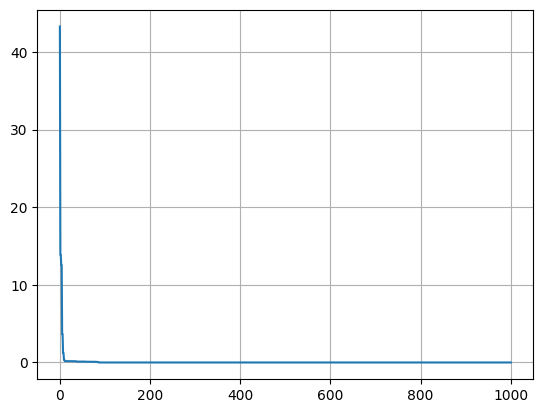

In [497]:
size = 20

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu =50$

Algorytm zajął: 0.20205s
Step: 2	 Position: [3.17830, -1.50714]	 Value: 8.18973
Step: 4	 Position: [3.15105, 1.90442]	 Value: 0.74418
Step: 6	 Position: [2.97904, 1.96734]	 Value: 0.04761
Step: 57	 Position: [3.00373, 2.02995]	 Value: 0.01822
Step: 112	 Position: [2.97967, 1.99954]	 Value: 0.01539
Step: 185	 Position: [2.98745, 2.02244]	 Value: 0.00882
Step: 303	 Position: [3.00868, 1.99719]	 Value: 0.00244
Step: 521	 Position: [3.00703, 1.99246]	 Value: 0.00173


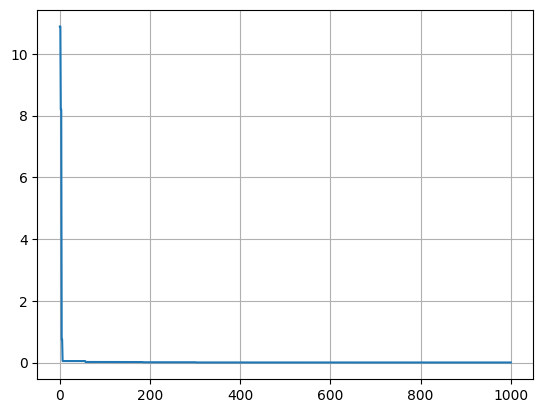

In [498]:
size = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

#### Ackley function

##### $\mu =5$

Algorytm zajął: 0.06302s
Step: 1	 Position: [-0.25075, -1.91873]	 Value: 5.96324
Step: 2	 Position: [-0.23582, -1.91887]	 Value: 5.88510
Step: 3	 Position: [-0.21772, -1.91383]	 Value: 5.78974
Step: 5	 Position: [-0.21156, -1.91382]	 Value: 5.75590
Step: 7	 Position: [-0.20371, -1.90264]	 Value: 5.72206
Step: 8	 Position: [-0.20426, -1.92509]	 Value: 5.70899
Step: 9	 Position: [-0.19304, -1.91025]	 Value: 5.65596
Step: 10	 Position: [-0.18206, -1.89851]	 Value: 5.60827
Step: 11	 Position: [-0.17119, -1.91124]	 Value: 5.53326
Step: 12	 Position: [-0.16211, -1.94488]	 Value: 5.46156
Step: 13	 Position: [-0.13874, -1.94702]	 Value: 5.32988
Step: 16	 Position: [-0.12495, -1.94256]	 Value: 5.25738
Step: 18	 Position: [-0.12182, -1.95250]	 Value: 5.23928
Step: 19	 Position: [-0.10866, -1.93522]	 Value: 5.18052
Step: 20	 Position: [-0.10643, -1.95973]	 Value: 5.16343
Step: 21	 Position: [-0.10309, -1.96696]	 Value: 5.15044
Step: 22	 Position: [-0.10131, -1.96351]	 Value: 5.14047
Step: 23	 Pos

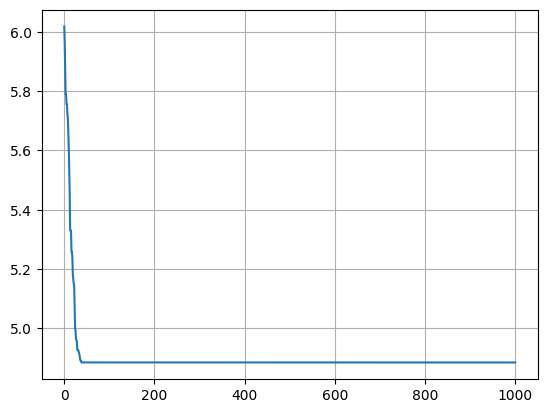

In [531]:
size = 5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 10$

Algorytm zajął: 0.11622s
Step: 1	 Position: [1.14845, 0.93378]	 Value: 4.36773
Step: 3	 Position: [-1.03627, 1.00083]	 Value: 3.72145
Step: 8	 Position: [-0.80652, -0.19881]	 Value: 3.54136
Step: 9	 Position: [-0.92115, 0.21582]	 Value: 3.49585
Step: 10	 Position: [-0.50812, 0.02989]	 Value: 3.11547
Step: 12	 Position: [-0.85634, -0.05120]	 Value: 2.81281
Step: 15	 Position: [-0.23030, 0.04355]	 Value: 1.64897
Step: 18	 Position: [0.01350, -0.05331]	 Value: 0.23420
Step: 19	 Position: [-0.02084, -0.03514]	 Value: 0.15949
Step: 44	 Position: [-0.02918, -0.01291]	 Value: 0.11719
Step: 207	 Position: [0.02063, 0.01362]	 Value: 0.08612
Step: 246	 Position: [-0.01363, 0.00958]	 Value: 0.05448
Step: 396	 Position: [-0.00650, 0.00050]	 Value: 0.01956


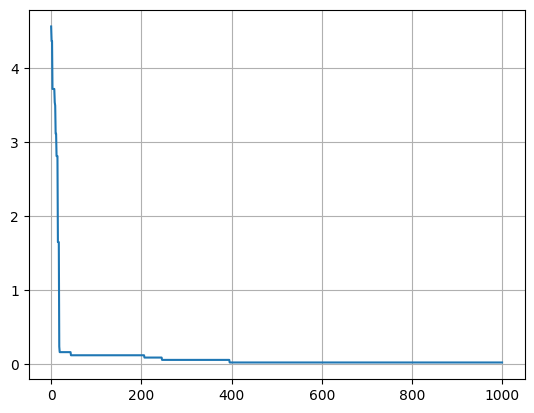

In [500]:
size = 10

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 20$

Algorytm zajął: 0.20949s
Step: 2	 Position: [-0.30656, -0.82705]	 Value: 4.00322
Step: 3	 Position: [-0.05874, -0.50292]	 Value: 3.13339
Step: 4	 Position: [-0.02191, -0.29697]	 Value: 2.12419
Step: 5	 Position: [0.07300, 0.21464]	 Value: 1.60131
Step: 6	 Position: [0.19678, -0.10042]	 Value: 1.56907
Step: 14	 Position: [0.01861, -0.02896]	 Value: 0.12866
Step: 46	 Position: [0.00644, 0.00142]	 Value: 0.01982


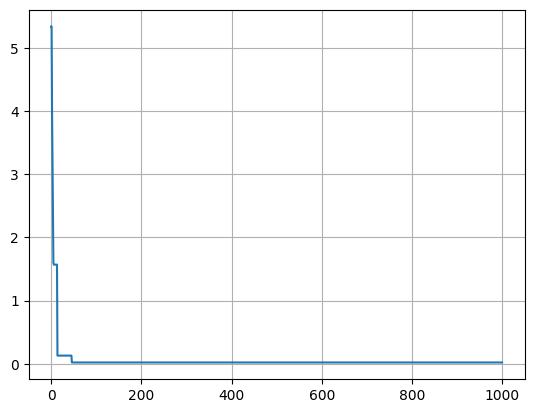

In [501]:
size = 20

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu =50$

Algorytm zajął: 0.48408s
Step: 2	 Position: [0.23402, -0.04020]	 Value: 1.67260
Step: 4	 Position: [0.03663, 0.15593]	 Value: 1.01631
Step: 5	 Position: [-0.08727, 0.11582]	 Value: 0.89863
Step: 6	 Position: [-0.09140, 0.03713]	 Value: 0.52040
Step: 10	 Position: [0.03849, -0.08866]	 Value: 0.50587
Step: 11	 Position: [-0.00169, 0.02849]	 Value: 0.10229
Step: 235	 Position: [-0.02446, 0.00493]	 Value: 0.08709
Step: 290	 Position: [0.00114, -0.00626]	 Value: 0.01907


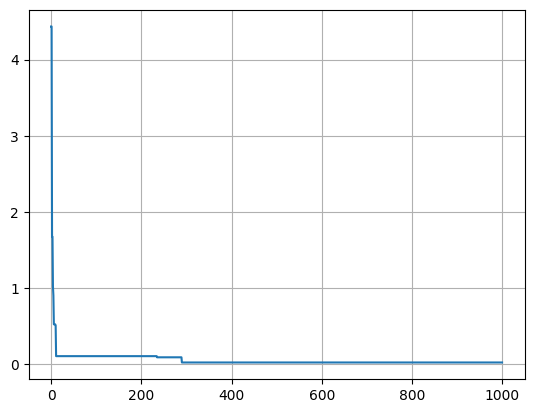

In [502]:
size = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


### Ilość iteracji - $t$

In [503]:
restrictions = ((-7,7),(-7,7))
size = 20
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $t = 50$

Algorytm zajął: 0.00554s
Step: 2	 Position: [3.25065, -0.12978]	 Value: 14.24865
Step: 4	 Position: [3.26851, -0.40363]	 Value: 13.25375
Step: 6	 Position: [3.34243, 0.73063]	 Value: 10.57231
Step: 7	 Position: [3.54923, -0.93824]	 Value: 7.04135
Step: 8	 Position: [3.08545, 1.38977]	 Value: 3.94079
Step: 9	 Position: [3.21352, 1.65349]	 Value: 2.06843
Step: 11	 Position: [3.22057, 1.90306]	 Value: 1.65079
Step: 12	 Position: [2.78237, 2.09425]	 Value: 1.38361
Step: 14	 Position: [2.96410, 2.10710]	 Value: 0.17464
Step: 26	 Position: [2.93770, 2.03454]	 Value: 0.11841
Step: 31	 Position: [2.97391, 1.97208]	 Value: 0.05254


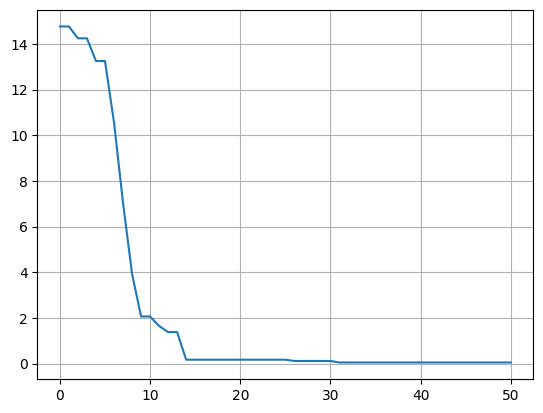

In [504]:
iterations = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 100$

Algorytm zajął: 0.00971s
Step: 2	 Position: [3.37375, -0.39522]	 Value: 12.04139
Step: 3	 Position: [3.05803, 1.10954]	 Value: 7.63936
Step: 4	 Position: [3.06489, 1.15937]	 Value: 6.91295
Step: 5	 Position: [2.66814, 2.30943]	 Value: 3.47308
Step: 6	 Position: [3.26542, 2.07821]	 Value: 3.37317
Step: 9	 Position: [2.71381, 2.19749]	 Value: 2.36172
Step: 10	 Position: [2.97458, 1.74152]	 Value: 1.15346
Step: 11	 Position: [2.84544, 2.09327]	 Value: 0.70802
Step: 17	 Position: [2.98631, 2.06931]	 Value: 0.07218
Step: 38	 Position: [2.99379, 1.99760]	 Value: 0.00182


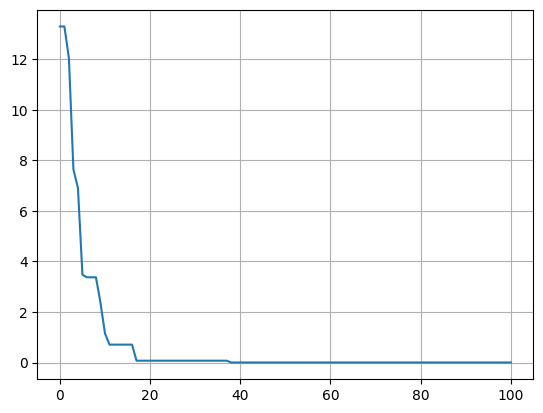

In [505]:
iterations = 100

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 1000$

Algorytm zajął: 0.09584s
Step: 84	 Position: [3.59078, -1.88343]	 Value: 0.01918
Step: 324	 Position: [3.57623, -1.86270]	 Value: 0.00748
Step: 612	 Position: [3.57768, -1.84693]	 Value: 0.00235


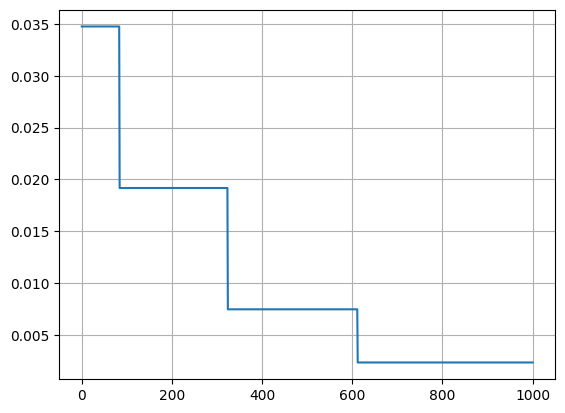

In [506]:
iterations = 1000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 10000$

Algorytm zajął: 0.88763s
Step: 1	 Position: [0.30233, 1.43211]	 Value: 111.39579
Step: 2	 Position: [0.25524, 1.86244]	 Value: 93.04149
Step: 3	 Position: [-0.46581, 1.98453]	 Value: 89.85631
Step: 4	 Position: [-0.49784, 2.02361]	 Value: 87.76669
Step: 5	 Position: [-0.80689, 2.00779]	 Value: 83.83017
Step: 6	 Position: [-1.53922, 2.57462]	 Value: 40.32744
Step: 7	 Position: [-2.11388, 2.54025]	 Value: 23.01093
Step: 11	 Position: [-2.26672, 2.85957]	 Value: 10.20159
Step: 12	 Position: [-2.18227, 3.07402]	 Value: 10.08037
Step: 14	 Position: [-2.75605, 2.88965]	 Value: 2.24152
Step: 19	 Position: [-2.74635, 3.23677]	 Value: 0.58214
Step: 20	 Position: [-2.80776, 3.02174]	 Value: 0.46707
Step: 27	 Position: [-2.78555, 3.08397]	 Value: 0.10001
Step: 42	 Position: [-2.78726, 3.10028]	 Value: 0.04794
Step: 44	 Position: [-2.81497, 3.13778]	 Value: 0.00476
Step: 227	 Position: [-2.79685, 3.13641]	 Value: 0.00332
Step: 759	 Position: [-2.80699, 3.12746]	 Value: 0.00072
Step: 3537	 Position

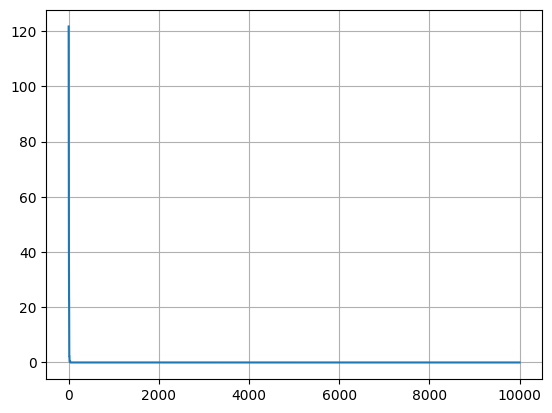

In [507]:
iterations = 10000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


#### Ackley function

##### $t = 50$

Algorytm zajął: 0.01147s
Step: 1	 Position: [0.26401, 0.39752]	 Value: 3.38191
Step: 2	 Position: [0.08729, 0.42314]	 Value: 2.91975
Step: 5	 Position: [0.11436, -0.34702]	 Value: 2.63115
Step: 8	 Position: [0.98918, -0.01792]	 Value: 2.62306
Step: 10	 Position: [-0.20271, 0.04837]	 Value: 1.43370
Step: 12	 Position: [-0.06983, 0.03370]	 Value: 0.37265
Step: 18	 Position: [-0.01104, 0.04615]	 Value: 0.19313
Step: 29	 Position: [0.04094, -0.01605]	 Value: 0.17515


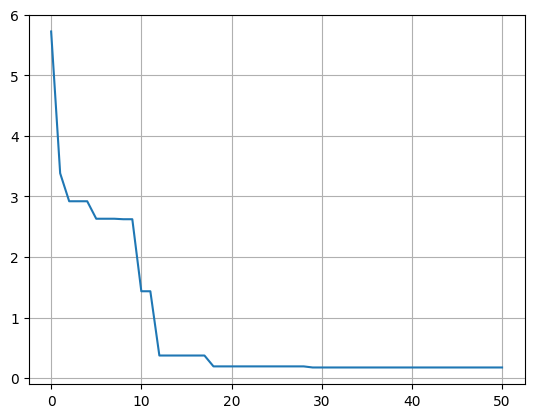

In [508]:
iterations = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 100$

Algorytm zajął: 0.02253s
Step: 3	 Position: [0.48155, 0.15701]	 Value: 3.29893
Step: 4	 Position: [0.74352, 0.01021]	 Value: 3.10082
Step: 5	 Position: [0.08742, -0.11000]	 Value: 0.86003
Step: 13	 Position: [0.06790, 0.02188]	 Value: 0.33215


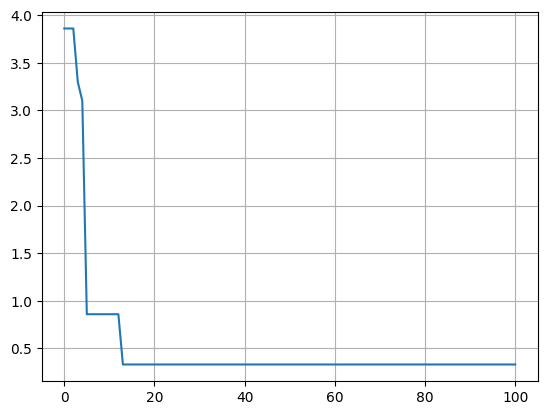

In [509]:
iterations = 100

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)



##### $t = 1000$

Algorytm zajął: 0.20071s
Step: 1	 Position: [0.80841, -1.26528]	 Value: 5.40402
Step: 2	 Position: [0.31011, -0.90454]	 Value: 3.99149
Step: 3	 Position: [0.95362, -0.84746]	 Value: 3.86806
Step: 4	 Position: [0.08102, -0.74693]	 Value: 3.20174
Step: 8	 Position: [0.10420, -0.41338]	 Value: 2.91911
Step: 11	 Position: [0.19518, -0.11904]	 Value: 1.64649
Step: 14	 Position: [0.03232, -0.06246]	 Value: 0.32603
Step: 20	 Position: [0.00276, -0.02807]	 Value: 0.10081
Step: 186	 Position: [-0.00686, 0.01484]	 Value: 0.05334
Step: 807	 Position: [-0.00764, 0.00348]	 Value: 0.02562


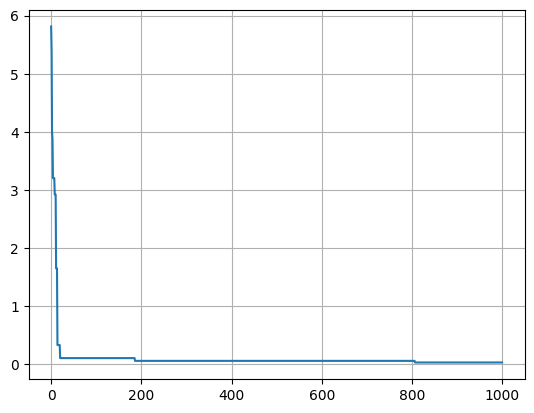

In [510]:
iterations = 1000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 10000$

Algorytm zajął: 2.01184s
Step: 6	 Position: [0.25854, -0.12471]	 Value: 2.12660
Step: 7	 Position: [0.24962, -0.06049]	 Value: 1.83887
Step: 9	 Position: [-0.02979, -0.07330]	 Value: 0.38299
Step: 13	 Position: [-0.05706, -0.00886]	 Value: 0.24974
Step: 30	 Position: [-0.00710, -0.04057]	 Value: 0.16107
Step: 140	 Position: [0.02917, 0.02865]	 Value: 0.15966
Step: 177	 Position: [-0.01405, 0.03126]	 Value: 0.12796
Step: 179	 Position: [-0.01925, -0.01598]	 Value: 0.08737
Step: 186	 Position: [-0.01023, -0.00296]	 Value: 0.03313
Step: 879	 Position: [-0.00418, 0.00287]	 Value: 0.01503
Step: 6486	 Position: [-0.00325, 0.00203]	 Value: 0.01123
Step: 9769	 Position: [-0.00114, -0.00024]	 Value: 0.00335


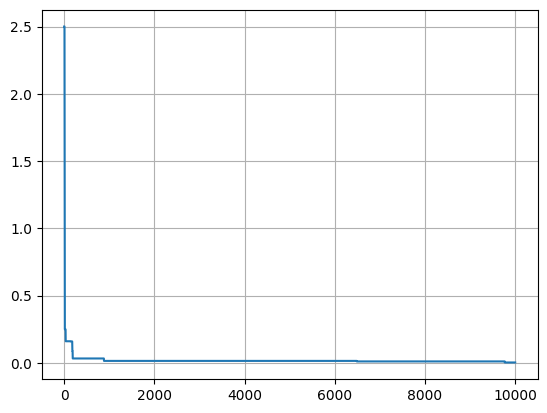

In [511]:
iterations = 10000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


### Siła mutacji - $\sigma$

In [512]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
crossover_probability =  0.1

#### Himmelblau function

##### $\sigma=0.5$

Algorytm zajął: 0.09041s
Step: 3	 Position: [3.19403, -1.49274]	 Value: 7.73726
Step: 4	 Position: [3.38334, -1.38246]	 Value: 3.78372
Step: 5	 Position: [3.72756, -1.59270]	 Value: 2.23645
Step: 9	 Position: [3.51940, -1.55676]	 Value: 1.14653
Step: 39	 Position: [3.60599, -1.84005]	 Value: 0.02668
Step: 49	 Position: [3.60574, -1.86613]	 Value: 0.02606
Step: 400	 Position: [3.59755, -1.88111]	 Value: 0.02228
Step: 898	 Position: [3.59048, -1.87047]	 Value: 0.00839


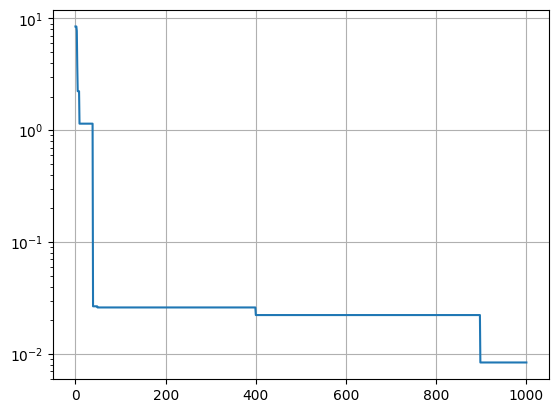

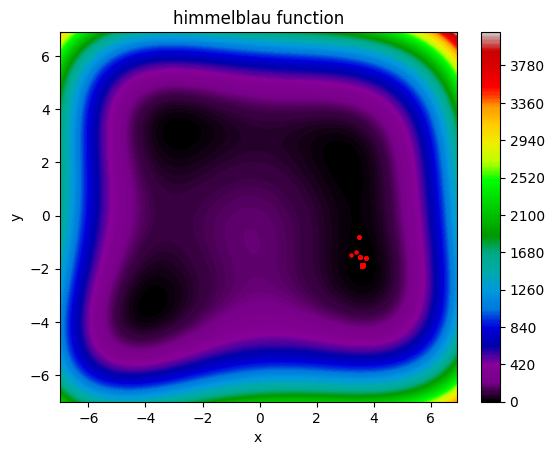

In [513]:
mutation_strength = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $\sigma=0.3$

Algorytm zajął: 0.08877s
Step: 2	 Position: [3.26143, 2.00010]	 Value: 2.74845
Step: 3	 Position: [3.24030, 2.01500]	 Value: 2.38409
Step: 5	 Position: [2.90861, 2.25352]	 Value: 1.05617
Step: 7	 Position: [2.90954, 1.94885]	 Value: 0.42859
Step: 9	 Position: [3.00029, 2.05865]	 Value: 0.06045
Step: 23	 Position: [3.00581, 2.00208]	 Value: 0.00157


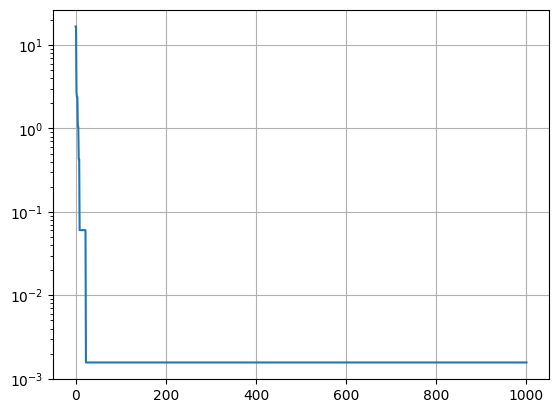

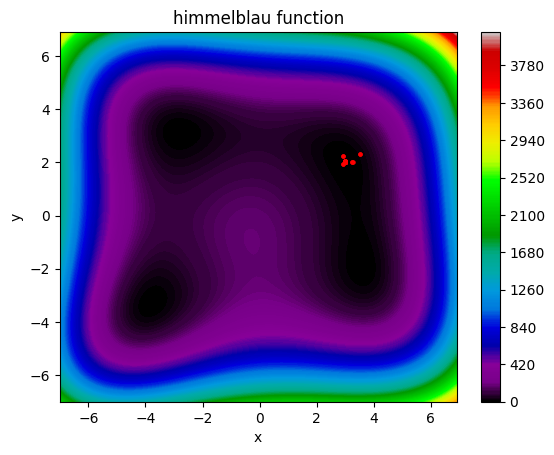

In [514]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



##### $\sigma=0.1$

Algorytm zajął: 0.09540s
Step: 1	 Position: [3.34227, 0.50055]	 Value: 12.05952
Step: 2	 Position: [3.77356, -2.32385]	 Value: 5.56436
Step: 4	 Position: [3.70697, -2.25620]	 Value: 3.46633
Step: 5	 Position: [3.76623, -2.17840]	 Value: 3.29723
Step: 8	 Position: [3.53818, -2.19034]	 Value: 2.23535
Step: 9	 Position: [3.57283, -2.18133]	 Value: 1.94494
Step: 10	 Position: [3.71618, -2.08318]	 Value: 1.64302
Step: 11	 Position: [3.62080, -2.08062]	 Value: 0.90298
Step: 12	 Position: [3.55460, -1.74231]	 Value: 0.17938
Step: 20	 Position: [3.57876, -1.80102]	 Value: 0.03157
Step: 27	 Position: [3.57115, -1.81010]	 Value: 0.02646
Step: 33	 Position: [3.59527, -1.86713]	 Value: 0.01009
Step: 47	 Position: [3.59526, -1.86157]	 Value: 0.00782
Step: 132	 Position: [3.58873, -1.85823]	 Value: 0.00218
Step: 163	 Position: [3.58564, -1.84698]	 Value: 0.00011


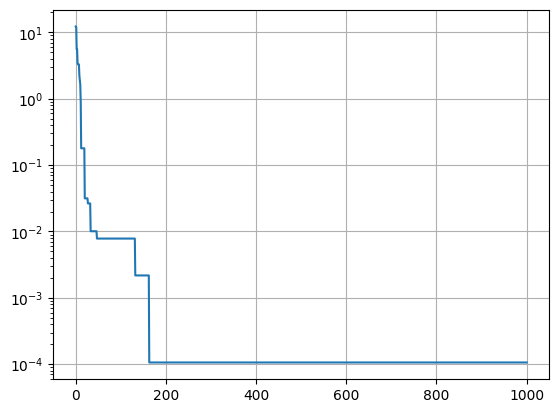

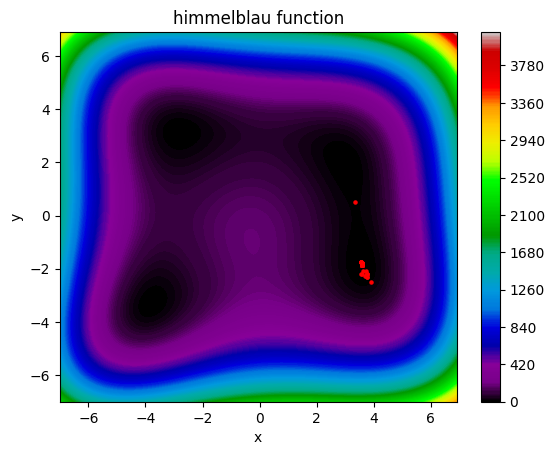

In [515]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $\sigma=0.01$

Algorytm zajął: 0.09523s
Step: 3	 Position: [-2.70455, 2.63890]	 Value: 8.60691
Step: 5	 Position: [-2.69483, 2.66354]	 Value: 7.91613
Step: 8	 Position: [-2.69653, 2.69729]	 Value: 6.92596
Step: 9	 Position: [-2.70353, 2.70272]	 Value: 6.73093
Step: 11	 Position: [-2.72517, 2.70466]	 Value: 6.56292
Step: 12	 Position: [-2.69975, 2.71577]	 Value: 6.39374
Step: 14	 Position: [-2.70336, 2.72246]	 Value: 6.19100
Step: 15	 Position: [-2.71053, 2.74172]	 Value: 5.64188
Step: 16	 Position: [-2.71492, 2.75292]	 Value: 5.33194
Step: 18	 Position: [-2.73898, 2.75619]	 Value: 5.14011
Step: 19	 Position: [-2.69803, 2.82933]	 Value: 3.66037
Step: 20	 Position: [-2.67149, 2.84847]	 Value: 3.45592
Step: 21	 Position: [-2.76700, 2.85437]	 Value: 2.86247
Step: 22	 Position: [-2.77250, 2.87264]	 Value: 2.50591
Step: 23	 Position: [-2.77442, 2.87823]	 Value: 2.40079
Step: 24	 Position: [-2.77228, 2.88551]	 Value: 2.27530
Step: 25	 Position: [-2.79204, 2.92530]	 Value: 1.60240
Step: 26	 Position: [-2.825

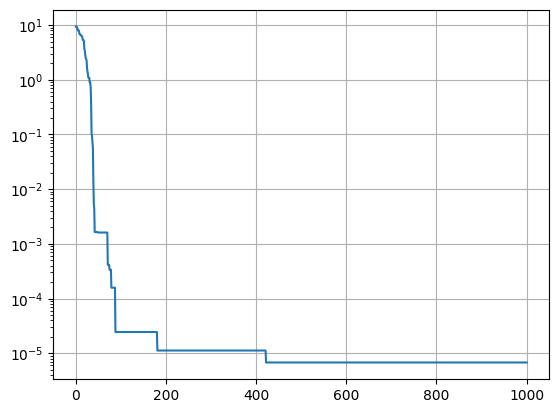

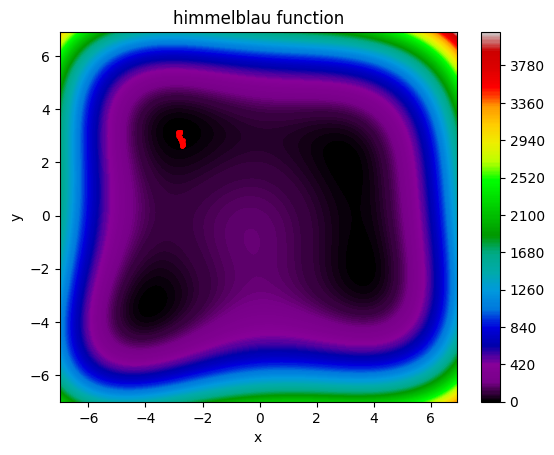

In [516]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


#### Ackley function

##### $\sigma=0.5$

Algorytm zajął: 0.20577s
Step: 1	 Position: [-0.04612, -0.65997]	 Value: 3.26953
Step: 3	 Position: [-0.04974, -0.38017]	 Value: 2.65651
Step: 5	 Position: [0.26398, 0.16592]	 Value: 2.34959
Step: 6	 Position: [-0.03670, -0.15738]	 Value: 1.02849
Step: 12	 Position: [-0.09295, -0.12886]	 Value: 1.02010
Step: 18	 Position: [-0.08900, 0.02578]	 Value: 0.47617
Step: 41	 Position: [0.05542, 0.00262]	 Value: 0.23684
Step: 73	 Position: [0.02273, -0.04554]	 Value: 0.21168
Step: 179	 Position: [-0.04250, -0.01840]	 Value: 0.18721
Step: 257	 Position: [0.01051, 0.03182]	 Value: 0.12443
Step: 405	 Position: [-0.01467, -0.02279]	 Value: 0.09613
Step: 474	 Position: [0.00783, 0.00209]	 Value: 0.02465


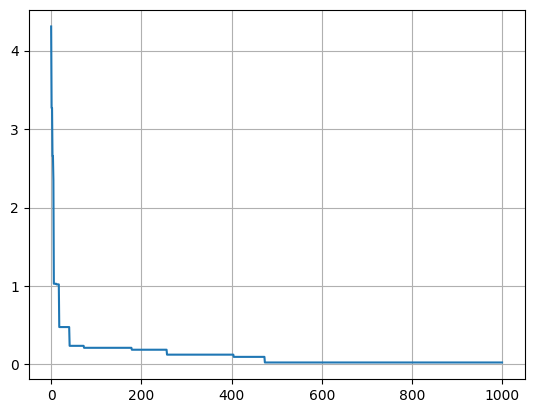

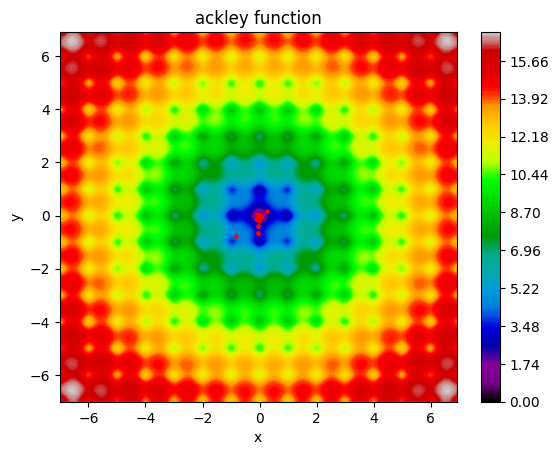

In [517]:
mutation_strength = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)



##### $\sigma=0.3$

Algorytm zajął: 0.20281s
Step: 6	 Position: [0.22356, -0.78050]	 Value: 3.69300
Step: 7	 Position: [-0.21606, 0.27280]	 Value: 2.64367
Step: 10	 Position: [-0.00557, 0.27701]	 Value: 1.97206
Step: 13	 Position: [0.04406, 0.12782]	 Value: 0.80790
Step: 14	 Position: [0.05978, -0.04671]	 Value: 0.36204
Step: 25	 Position: [0.04466, 0.05104]	 Value: 0.31064
Step: 71	 Position: [0.01239, -0.03790]	 Value: 0.15460
Step: 175	 Position: [-0.03748, -0.00566]	 Value: 0.14502
Step: 262	 Position: [0.00419, 0.00888]	 Value: 0.03033
Step: 352	 Position: [-0.00426, 0.00864]	 Value: 0.02972


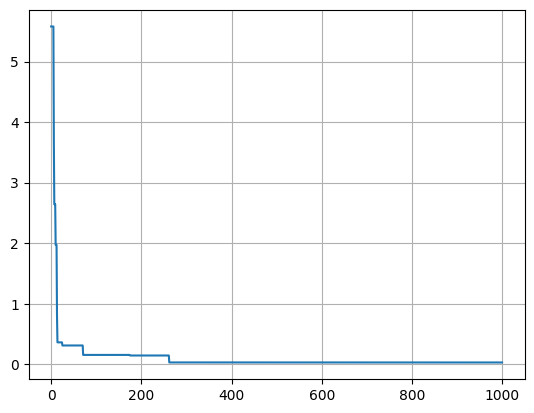

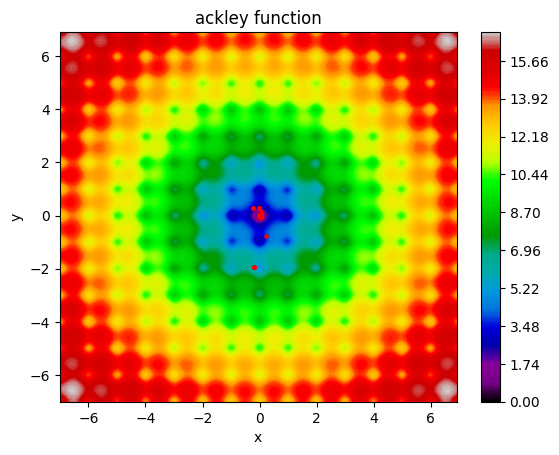

In [518]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


##### $\sigma=0.1$

Algorytm zajął: 0.20521s
Step: 2	 Position: [0.08477, -0.30331]	 Value: 2.28430
Step: 3	 Position: [0.01891, -0.29466]	 Value: 2.10573
Step: 4	 Position: [-0.25253, 0.01091]	 Value: 1.78685
Step: 6	 Position: [-0.05610, -0.03475]	 Value: 0.29916
Step: 20	 Position: [0.03233, -0.00753]	 Value: 0.12298
Step: 21	 Position: [-0.02274, -0.00938]	 Value: 0.08561
Step: 49	 Position: [-0.00912, -0.01562]	 Value: 0.05984
Step: 58	 Position: [0.00165, 0.01459]	 Value: 0.04726
Step: 76	 Position: [0.00424, -0.00910]	 Value: 0.03107
Step: 181	 Position: [-0.00254, 0.00175]	 Value: 0.00896
Step: 220	 Position: [-0.00219, 0.00167]	 Value: 0.00801
Step: 938	 Position: [-0.00011, 0.00239]	 Value: 0.00692


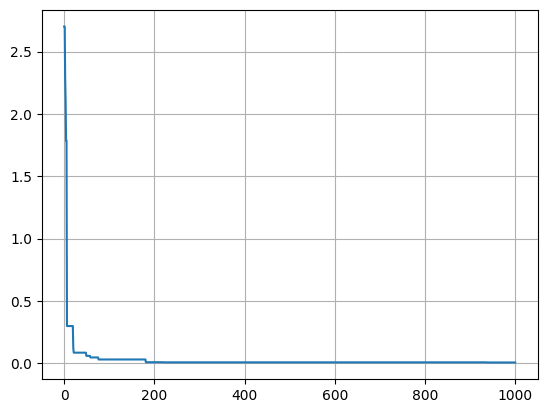

In [519]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $\sigma=0.01$

Algorytm zajął: 0.20229s
Step: 2	 Position: [0.42592, 0.08231]	 Value: 2.92050
Step: 3	 Position: [0.43171, 0.06791]	 Value: 2.91642
Step: 4	 Position: [0.39812, 0.08127]	 Value: 2.79933
Step: 6	 Position: [0.39817, 0.07841]	 Value: 2.79359
Step: 8	 Position: [0.38763, 0.07090]	 Value: 2.72907
Step: 9	 Position: [0.38358, 0.05678]	 Value: 2.68429
Step: 10	 Position: [0.36743, 0.09087]	 Value: 2.67270
Step: 11	 Position: [0.35025, 0.11387]	 Value: 2.64694
Step: 12	 Position: [0.32187, 0.01667]	 Value: 2.28754
Step: 13	 Position: [0.31212, 0.02371]	 Value: 2.22875
Step: 14	 Position: [0.30732, -0.00526]	 Value: 2.18704
Step: 15	 Position: [0.29327, -0.00759]	 Value: 2.09036
Step: 16	 Position: [0.27660, -0.03798]	 Value: 1.99677
Step: 18	 Position: [0.26024, -0.01608]	 Value: 1.84985
Step: 20	 Position: [0.25046, 0.00013]	 Value: 1.76794
Step: 22	 Position: [0.24582, -0.01457]	 Value: 1.73579
Step: 23	 Position: [0.22401, -0.00899]	 Value: 1.55554
Step: 25	 Position: [0.20333, 0.01456]	 

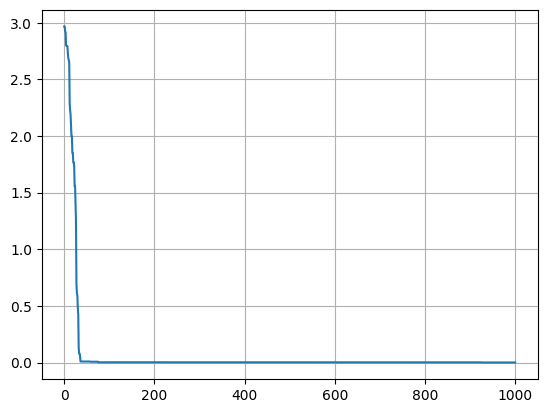

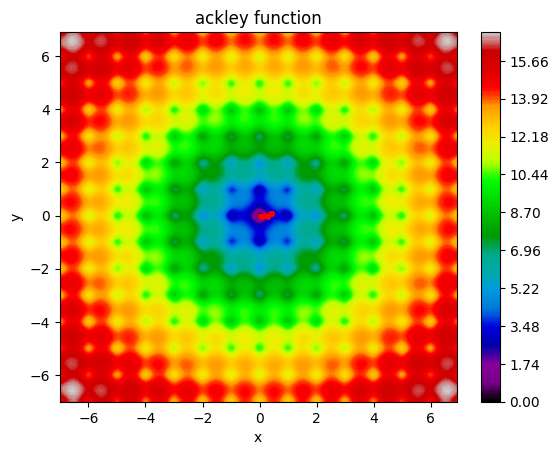

In [520]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


### Prawdopodobieństwo krzyżowania $p_c$

In [521]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
mutation_strength = 0.3

#### Himmelblau function

##### $p_c=0.5$

Algorytm zajął: 0.09829s
Step: 5	 Position: [-3.86802, -3.41058]	 Value: 0.88736
Step: 6	 Position: [-3.75403, -3.32500]	 Value: 0.14490
Step: 15	 Position: [-3.74295, -3.25384]	 Value: 0.08378
Step: 37	 Position: [-3.74757, -3.27038]	 Value: 0.05385
Step: 49	 Position: [-3.79909, -3.29956]	 Value: 0.02558
Step: 104	 Position: [-3.78111, -3.26954]	 Value: 0.00906
Step: 197	 Position: [-3.78191, -3.29464]	 Value: 0.00536
Step: 644	 Position: [-3.77160, -3.27564]	 Value: 0.00432
Step: 727	 Position: [-3.78237, -3.27687]	 Value: 0.00285
Step: 807	 Position: [-3.78182, -3.27770]	 Value: 0.00208


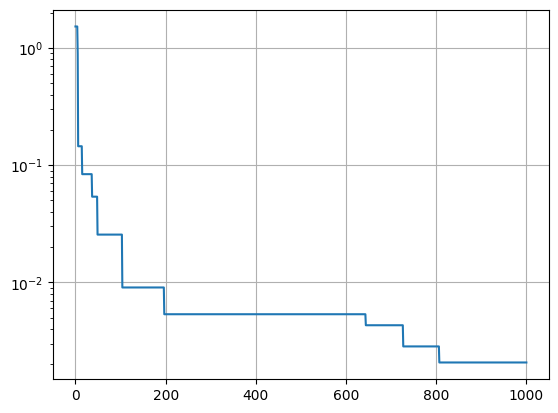

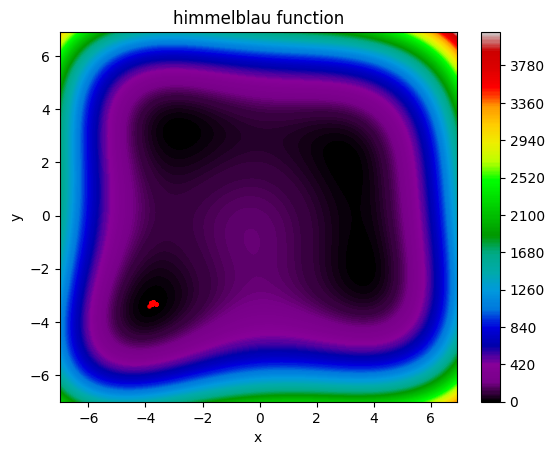

In [522]:
crossover_probability = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.3$

Algorytm zajął: 0.09581s
Step: 1	 Position: [3.59686, -1.64270]	 Value: 0.58342
Step: 2	 Position: [3.63451, -1.71324]	 Value: 0.43163
Step: 11	 Position: [3.54450, -1.79695]	 Value: 0.10582
Step: 14	 Position: [3.55485, -1.81764]	 Value: 0.05262
Step: 20	 Position: [3.61569, -1.84764]	 Value: 0.05175
Step: 24	 Position: [3.60774, -1.88346]	 Value: 0.04158
Step: 36	 Position: [3.59342, -1.84044]	 Value: 0.00559
Step: 151	 Position: [3.57447, -1.84121]	 Value: 0.00540
Step: 222	 Position: [3.58369, -1.83787]	 Value: 0.00151
Step: 576	 Position: [3.58717, -1.84864]	 Value: 0.00039


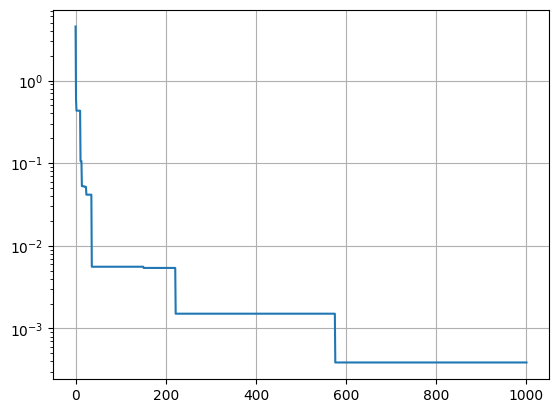

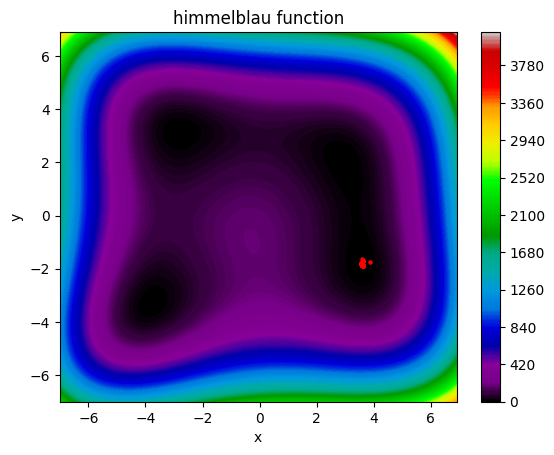

In [523]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.1$

Algorytm zajął: 0.09604s
Step: 1	 Position: [3.57409, -1.67168]	 Value: 0.40916
Step: 5	 Position: [3.59469, -1.81893]	 Value: 0.01996
Step: 9	 Position: [3.58356, -1.85404]	 Value: 0.00059
Step: 112	 Position: [3.58595, -1.84773]	 Value: 0.00013
Step: 315	 Position: [3.58360, -1.84723]	 Value: 0.00004


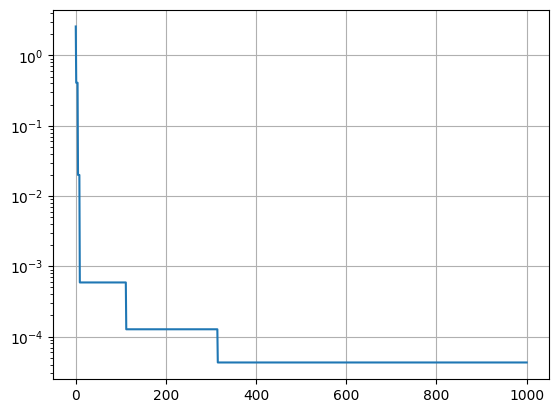

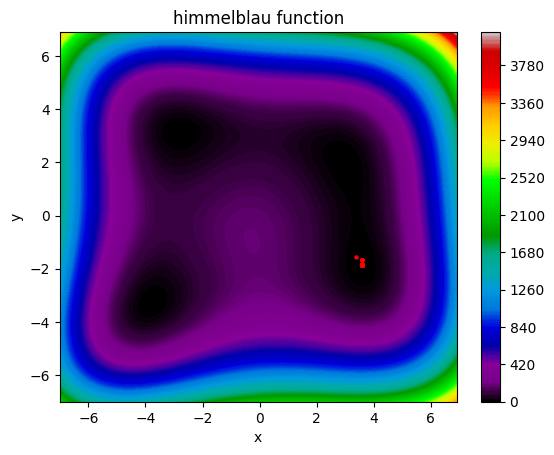

In [524]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.01$

Algorytm zajął: 0.10421s
Step: 1	 Position: [2.12121, 2.20855]	 Value: 18.42038
Step: 2	 Position: [3.58966, -1.10714]	 Value: 5.37843
Step: 5	 Position: [3.28692, 1.91573]	 Value: 2.95888
Step: 6	 Position: [2.75792, 1.96775]	 Value: 2.17072
Step: 7	 Position: [3.05145, 1.94465]	 Value: 0.09339
Step: 8	 Position: [3.01456, 1.96916]	 Value: 0.01485
Step: 11	 Position: [2.99859, 1.97930]	 Value: 0.00787
Step: 12	 Position: [3.00367, 1.98318]	 Value: 0.00404
Step: 13	 Position: [3.00406, 1.98737]	 Value: 0.00228
Step: 14	 Position: [3.00791, 1.99228]	 Value: 0.00211
Step: 15	 Position: [2.99704, 2.00644]	 Value: 0.00065
Step: 22	 Position: [2.99977, 2.00580]	 Value: 0.00055
Step: 23	 Position: [3.00114, 2.00124]	 Value: 0.00010
Step: 25	 Position: [2.99962, 2.00162]	 Value: 0.00004
Step: 36	 Position: [2.99968, 2.00110]	 Value: 0.00002
Step: 83	 Position: [3.00018, 1.99949]	 Value: 0.00000
Step: 218	 Position: [2.99989, 1.99979]	 Value: 0.00000
Step: 242	 Position: [2.99998, 1.99987]	 Va

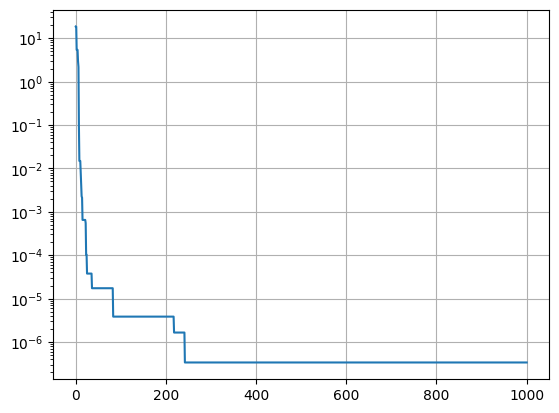

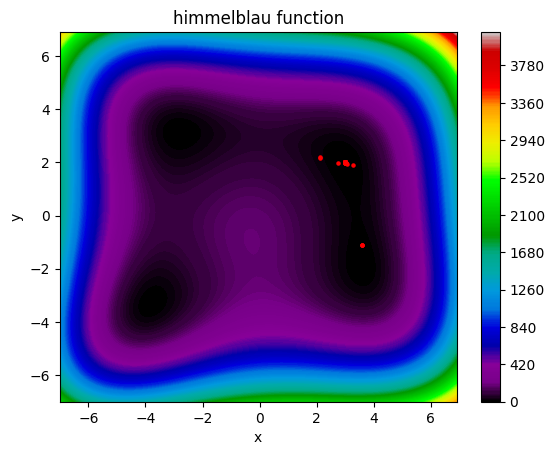

In [525]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


#### Ackley function

##### $p_c=0.5$

Algorytm zajął: 0.22255s
Step: 2	 Position: [1.22172, 0.83927]	 Value: 5.07513
Step: 3	 Position: [0.83265, -0.06084]	 Value: 2.90741
Step: 5	 Position: [-0.41570, -0.00607]	 Value: 2.78974
Step: 6	 Position: [-0.01180, 0.02135]	 Value: 0.08478
Step: 325	 Position: [-0.01102, -0.00705]	 Value: 0.04156
Step: 772	 Position: [-0.00198, -0.01033]	 Value: 0.03270


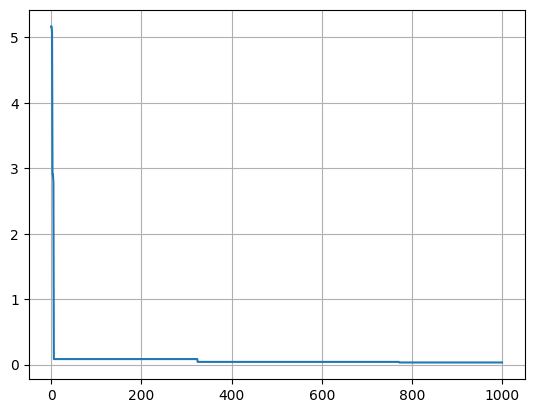

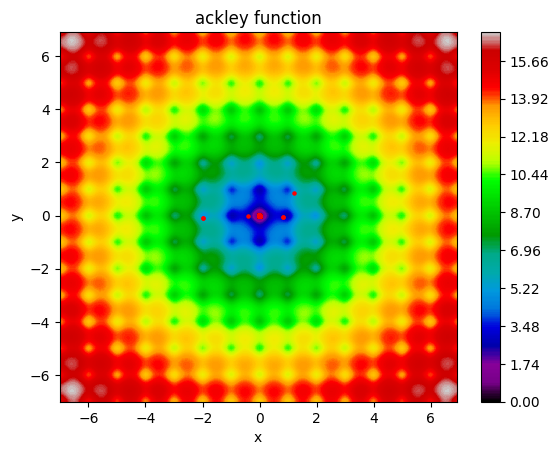

In [526]:
mutation_strength = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.3$

Algorytm zajął: 0.20923s
Step: 1	 Position: [1.41553, -2.54438]	 Value: 9.06695
Step: 2	 Position: [-0.29866, 0.54454]	 Value: 3.86794
Step: 3	 Position: [0.14864, 0.95321]	 Value: 3.09650
Step: 4	 Position: [0.04013, -0.17728]	 Value: 1.20245
Step: 6	 Position: [0.05260, 0.09483]	 Value: 0.59534
Step: 7	 Position: [-0.00462, -0.07264]	 Value: 0.34099
Step: 9	 Position: [0.05102, -0.01310]	 Value: 0.22129
Step: 16	 Position: [0.02139, 0.01620]	 Value: 0.09499
Step: 24	 Position: [-0.00678, -0.01109]	 Value: 0.04126
Step: 224	 Position: [0.00371, -0.00714]	 Value: 0.02447


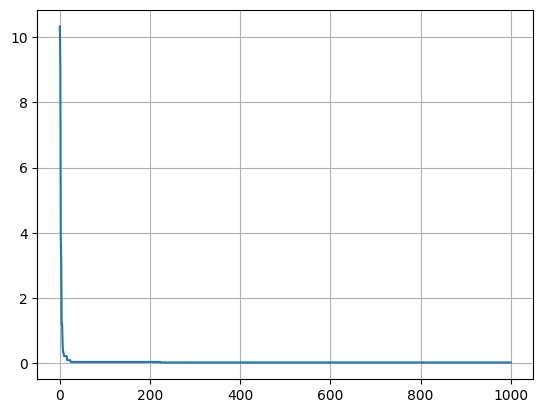

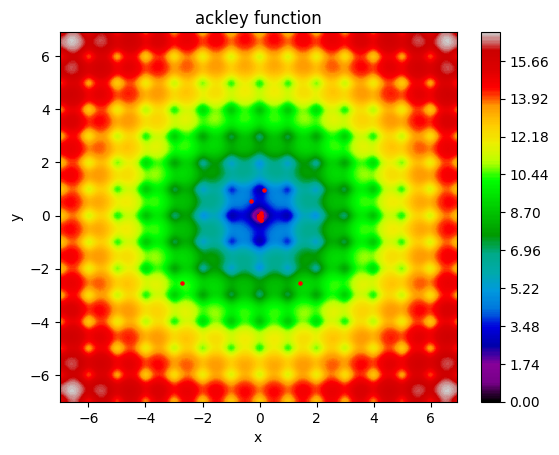

In [527]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.1$

Algorytm zajął: 0.21726s
Step: 2	 Position: [-0.31092, 0.20226]	 Value: 2.77860
Step: 3	 Position: [0.28270, 0.00170]	 Value: 2.01330
Step: 4	 Position: [0.06360, -0.15679]	 Value: 1.10157
Step: 5	 Position: [-0.11460, -0.06769]	 Value: 0.79484
Step: 6	 Position: [0.05073, -0.03766]	 Value: 0.28217
Step: 8	 Position: [0.01989, 0.00226]	 Value: 0.06724
Step: 10	 Position: [0.00038, 0.01766]	 Value: 0.05823
Step: 15	 Position: [-0.00864, 0.00457]	 Value: 0.03019
Step: 26	 Position: [-0.00164, 0.00407]	 Value: 0.01293
Step: 44	 Position: [-0.00024, -0.00370]	 Value: 0.01084
Step: 202	 Position: [-0.00102, 0.00235]	 Value: 0.00741
Step: 205	 Position: [-0.00133, -0.00101]	 Value: 0.00480
Step: 611	 Position: [-0.00005, 0.00129]	 Value: 0.00371


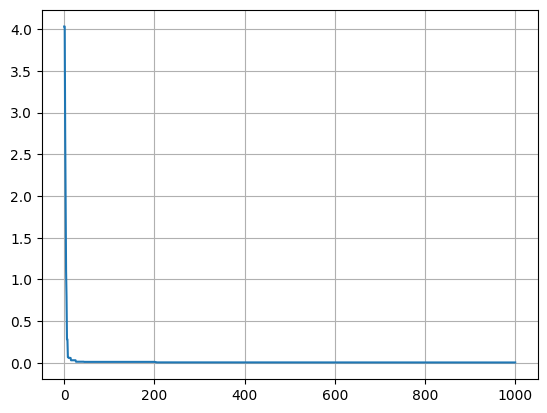

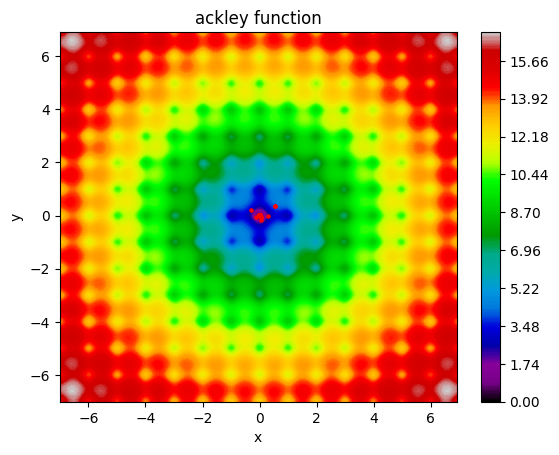

In [528]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.01$

Algorytm zajął: 0.21383s
Step: 1	 Position: [0.15968, 0.05621]	 Value: 1.09990
Step: 4	 Position: [0.15443, 0.06136]	 Value: 1.07462
Step: 5	 Position: [-0.09280, 0.03555]	 Value: 0.52553
Step: 6	 Position: [0.02085, 0.04696]	 Value: 0.21426
Step: 7	 Position: [0.01307, 0.04441]	 Value: 0.18708
Step: 9	 Position: [-0.00504, 0.02180]	 Value: 0.07656
Step: 10	 Position: [-0.00920, -0.00622]	 Value: 0.03471
Step: 12	 Position: [-0.00296, 0.00469]	 Value: 0.01650
Step: 14	 Position: [0.00252, 0.00394]	 Value: 0.01382
Step: 15	 Position: [-0.00085, -0.00140]	 Value: 0.00469
Step: 23	 Position: [0.00085, -0.00071]	 Value: 0.00316
Step: 31	 Position: [0.00061, -0.00083]	 Value: 0.00295
Step: 44	 Position: [0.00054, -0.00028]	 Value: 0.00173
Step: 73	 Position: [0.00036, -0.00002]	 Value: 0.00101
Step: 225	 Position: [0.00007, -0.00018]	 Value: 0.00054
Step: 719	 Position: [-0.00006, -0.00014]	 Value: 0.00044


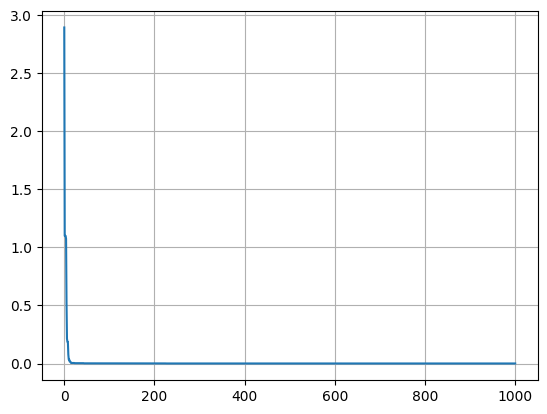

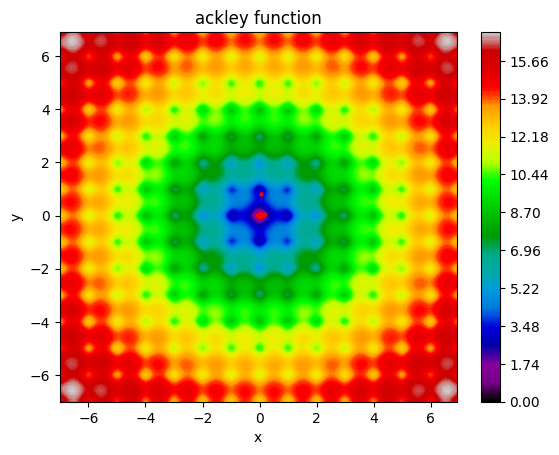

In [529]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)